# Seewassertemperatur aus Satellitendaten abgeleitet

Dieses Datenset liefert tägliche Werte der Oberflächenwassertemperatur von Seen (LSWT) am Vormittag, abgeleitet aus Satellitendaten, zusammen mit zugehöriger Unsicherheit und Qualitätsstufen. Die Daten, die von den ATSR- und AVHRR-Sensoren stammen, wurden zur Konsistenzanpassung bias-korrigiert und können aufgrund fehlender Beobachtungen Lücken enthalten. LSWT ist eine essenzielle Klimavariable, die für das Verständnis der Seeökologie, hydrologischer Prozesse und großräumiger Klimawechselwirkungen von entscheidender Bedeutung ist. Die Datenentwicklung wurde durch das UK NERC GloboLakes-Projekt unterstützt, und zukünftige Verbesserungen erfolgen im Rahmen der ESA Climate Change Initiative.

**Schnellnavigation:**
* [Herunterladen und Entpacken des Datensatzes](#herunterladen-und-entpacken-des-datensatzes)
* [NetCDF4-Dateien zusammenführen](#netcdf4-Dateien-zusammenführen)
* [Untersuchen der Metadaten der netCDF4-Datei](#untersuchen-der-metadaten-der-netcdf4-datei)
* [Exportieren der Zeitreihe im csv-Format](#exportieren-der-zeitreihe-im-csv-format)
* [Analyse und Visualisierung](#analyse-und-visualisierungsmöglichkeiten)

**Information on Dataset:**
* Quelle: <a href="https://cds.climate.copernicus.eu/datasets/satellite-lake-water-temperature?tab=overview" target="_blank">Satellite Lake Water Temperature</a>
* Author: T. Tewes (City of Konstanz)
* Notebook Version: 1.3 (Updated: January 17, 2025)

## 1. Festlegen der Pfade und Arbeitsverzeichnisse

In [1]:
import os

''' ---- Hier die Verzeichnisse angeben ---- '''
download_folder = r".\data\satellite-lake-water-temperature\download"
working_folder = r".\data\satellite-lake-water-temperature\working"
geotiff_folder = r".\data\satellite-lake-water-temperature\geotiff"
csv_folder = r".\data\satellite-lake-water-temperature\csv"
output_folder = r".\data\satellite-lake-water-temperature\output"
''' ----- Ende der Eingaben ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Herunterladen und Entpacken des Datensatzes

### 2.1 Authentifizierung

In [2]:
import cdsapi

def main():
    # API-Schlüssel für die Authentifizierung
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"

    # Erstellung des CDS-API-Clients
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Definieren Sie die "request" und laden Sie den Datensatz herunter

Definieren Sie zusätzliche Anfragefelder, um sicherzustellen, dass die Anfrage innerhalb der Dateigrößenbeschränkung bleibt. Bei der Arbeit mit Geodaten oder APIs, die Karten- oder Satellitenbilder zurückgeben, kann die Begrenzung des geografischen Interessengebiets verhindern, dass Anfragen zu groß werden und die Datei- oder Verarbeitungsgrenzen überschreiten. Begrenzungsrahmen (Bounding Boxes) werden verwendet, um das geografische Gebiet für solche Anfragen festzulegen.

Die untenstehenden Koordinaten wurden mit dem Tool <a href="https://str-ucture.github.io/bbox-extractor/" target="_blank">BBox Extractor</a> ermittelt.

*BBox Extractor ist ein webbasiertes Tool, das Benutzern hilft, interaktiv Begrenzungsrahmen-Koordinaten im WGS84-Format (Breite/Länge) auszuwählen und zu generieren. Dies ist besonders nützlich für APIs oder Datensätze, die eine Eingabe eines geografischen Gebiets erfordern*

In [3]:
# Definieren der Begrenzungsrahmen-Koordinaten (WGS84-Format) für die Region Bodensee.
# Das Koordinatenformat lautet: [Norden, Westen, Süden, Osten]
bbox_wgs84_constance = [48.0, 8.7, 47.3, 9.9]

In [4]:
# Geben Sie das Jahr von Interesse für die Datenanforderung an.
# Die entsprechende Datenversion hängt vom Jahr ab.
year = 2007

# Bestimmen Sie die Datenversion basierend auf dem Jahr:
# Version "4_5_1" wird für Jahre bis 2020 verwendet, und "4_5_2" für spätere Jahre.
if 1900 <= year <= 2100:  # Überprüfen Sie den gültigen Jahresbereich für Robustheit.
    version = "4_5_1" if year <= 2020 else "4_5_2"
else:
    raise ValueError(f"Ungültiges Jahr: {year}. Bitte geben Sie ein Jahr zwischen 1900 und 2100 an.")

In [5]:
# Definition des Datensatzes und der Request-Parameter
dataset = "satellite-lake-water-temperature"
request = {
    "variable": "all",
    "year": [f"{year}"],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "version": version,
    "area": bbox_wgs84_constance
}

In [6]:
# Führen Sie es aus, um den Datensatz herunterzuladen:
def main_retrieve():
    dataset_filename = f"{dataset}_{request['year'][0]}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)
    
    # Den Datensatz nur herunterladen, wenn er noch nicht heruntergeladen wurde
    if not os.path.isfile(dataset_filepath):
        # Rufen Sie den CDS-Client nur auf, wenn der Datensatz noch nicht heruntergeladen wurde.
        client = main()
        # Den Datensatz mit den definierten Anforderungsparametern herunterladen
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Datensatz bereits heruntergeladen.")
        
if __name__ == "__main__":
    main_retrieve()

Datensatz bereits heruntergeladen.


### 2.3 Extrahieren Sie die ZIP-Dateien in Ordner

In [7]:
import zipfile

# Construct the dataset filename and path
dataset_filename = f"{dataset}_{year}.zip"
dataset_filepath = os.path.join(download_folder, dataset_filename)
extract_folder = os.path.join(working_folder, str(year))

# Extract the zip file
try:
    os.makedirs(extract_folder, exist_ok=True)
    
    if not os.listdir(extract_folder):
        with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Successfully extracted files to: {extract_folder}")
    else:
        print("Folder is not empty. Skipping extraction.")
except FileNotFoundError:
    print(f"Error: The file {dataset_filepath} was not found.")
except zipfile.BadZipFile:
    print(f"Error: The file {dataset_filepath} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully extracted files to: .\data\satellite-lake-water-temperature\working\2007


## 3. NetCDF4-Dateien zusammenführen

Most Yearly dataset is available for all 365days (366days for leap year).
> Important: Daily dataset may have sparse or no data. Hence, merged netCDF, merged GeoTIFF or individual GeoTIFF files may comtain empty at some time instances.

In [8]:
import xarray as xr

# Filter the list of filenames
nc_filepath_merged = os.path.join(output_folder,f"{dataset}_{year}.nc")

if not os.path.isfile(nc_filepath_merged):
    filename_list = os.listdir(extract_folder)

    # Load all NetCDF files into a list of datasets
    datasets = [xr.open_dataset(os.path.join(extract_folder, f)) for f in filename_list]
    merged_dataset = xr.concat(datasets, dim='time')

    # Save the merged dataset into a new NetCDF file
    merged_dataset.to_netcdf(nc_filepath_merged)
    print(f"New NetCDF4 file created at {nc_filepath_merged} for year {year}")
else:
    print(f"Merged netCDF file already exists. Skipping merge.")

New NetCDF4 file created at .\data\satellite-lake-water-temperature\output\satellite-lake-water-temperature_2007.nc for year 2007


## 4. Untersuchen der Metadaten der netCDF4-Datei

In [9]:
import netCDF4 as nc

# Open the NetCDF file in read mode
nc_filename = f"satellite-lake-water-temperature_{year}.nc"
nc_filepath = os.path.join(output_folder, nc_filename)

# Open the NetCDF file in read mode
nc_dataset = nc.Dataset(nc_filepath_merged, mode="r")

# List all variables in the dataset
variables_list = nc_dataset.variables.keys()
print(f"Available variables: {list(variables_list)}")

Available variables: ['lake_surface_water_temperature', 'lswt_uncertainty', 'lswt_quality_level', 'lswt_obs_instr', 'lswt_flag_bias_correction', 'lakeid_CCI', 'lakeid_GloboLakes', 'lat', 'lon', 'time']


In [10]:
import pandas as pd

# Define variable name from available variables and read variable data
variable_name = 'lake_surface_water_temperature'
variable_data = nc_dataset[variable_name]

# Generate summary of the primary variable
summary = {
    "Variable Name": variable_name,
    "Data Type": variable_data.dtype,
    "Shape": variable_data.shape,
    "Variable Info": f"{variable_name}({', '.join(variable_data.dimensions)})",
    "Units": getattr(variable_data, "units", "N/A"),
    "Long Name": getattr(variable_data, "long_name", "N/A"),
}

# Display dataset summary as a DataFrame for better visualization
nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Remarks'])

# Display the summary DataFrame
nc_summary

,Description,Remarks
0,Variable Name,lake_surface_water_temperature
1,Data Type,int16
2,Shape,"(365, 14, 24)"
3,Variable Info,"lake_surface_water_temperature(time, lat, lon)"
4,Units,kelvin
5,Long Name,lake surface skin water temperature


## 4. Export Dataset to CSV

### 4.1 Compute Daily Average and Export as CSV

In [11]:
import netCDF4 as nc
import pandas as pd
from datetime import datetime
import numpy as np

def netcdf_to_dataframe(nc_file):
    # Open the dataset
    with nc.Dataset(nc_file, "r") as nc_dataset:
        # Extract and decode time variable
        time_var = nc_dataset.variables["time"]
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)

        # Extract and calculate temperature values
        temperature_data = nc_dataset.variables["lake_surface_water_temperature"][:]
        temperature_data_units = nc_dataset.variables["lake_surface_water_temperature"].units
        temperature_mean_list = np.nanmean(temperature_data, axis=(1, 2))
        temperature_std_list = np.nanstd(temperature_data, axis=(1, 2))
        
        # Counts the number of valid (non-NaN) pixels per day in the dataset
        # Daily dataset may have sparse or no data on some days.
        nonzero_count_list = np.count_nonzero(~np.isnan(temperature_data), axis=(1,2))

        lswt_uncertainty = nc_dataset.variables["lswt_uncertainty"][:]
        lswt_uncertainty_units = nc_dataset.variables["lswt_uncertainty"].units
        # lswt_uncertainty_mean_list = np.nanmean(lswt_uncertainty, axis=(1, 2))
        # Error propagation for uncertainty of mean temperature
        lswt_uncertainty_squared = np.nanmean(lswt_uncertainty**2, axis=(1, 2))
        lswt_mean_uncertainty = np.sqrt(lswt_uncertainty_squared)
        
        lswt_quality_level = nc_dataset.variables["lswt_quality_level"][:]
        lswt_quality_level_mean_list = np.nanmean(lswt_quality_level, axis=(1, 2))

        # Create DataFrame
        df = pd.DataFrame(
            {
                "Time": cftime,
                f"Mean Temperature ({temperature_data_units[0].capitalize()})": temperature_mean_list,
                "Std Dev": temperature_std_list,
                f"Uncertainty ({lswt_uncertainty_units[0].capitalize()})": lswt_mean_uncertainty,
                f"Mean Quality Level": lswt_quality_level_mean_list,
                "Non-Zero Count":nonzero_count_list,
            }
        )
        return df
    
# Modify display format for numbers in the DataFrames
pd.options.display.float_format = '{:,.2f}'.format

# Generate DataFrame (".dropna(): filters with NaN values)
df = netcdf_to_dataframe(nc_filepath_merged)
filtered_df = netcdf_to_dataframe(nc_filepath_merged).dropna().reset_index(drop=True)

# Generate the output file path
csv_filename = f"satellite-lake-water-temperature_daily-mean-{year}.csv"
csv_filepath = os.path.join(csv_folder, csv_filename)

# Export the filtered data to a CSV file if it doesn't already exist
if not os.path.isfile(csv_filepath):
    filtered_df.to_csv(csv_filepath, index=False)
    print(f"Filtered data exported successfully to {csv_filepath}")
else:
    print(f"File already exists at {csv_filepath}. Skipping export.")

# Display the filtered DataFrame
filtered_df.head()

Filtered data exported successfully to .\data\satellite-lake-water-temperature\csv\satellite-lake-water-temperature_daily-mean-2007.csv


,Time,Mean Temperature (K),Std Dev,Uncertainty (K),Mean Quality Level,Non-Zero Count
0,2007-01-02 12:00:00,278.46,0.11,0.43,4.86,7.00
1,2007-01-05 12:00:00,275.98,0.58,0.29,3.60,5.00
2,2007-01-06 12:00:00,278.64,0.00,0.34,4.00,1.00
3,2007-01-11 12:00:00,277.96,1.43,0.18,3.14,7.00
4,2007-01-14 12:00:00,278.68,0.76,0.19,4.30,20.00


### 4.2 Plot Daily Average
> Note: Due to limited daily/monthly data for 2023 dataset, **Plots** do not work properly

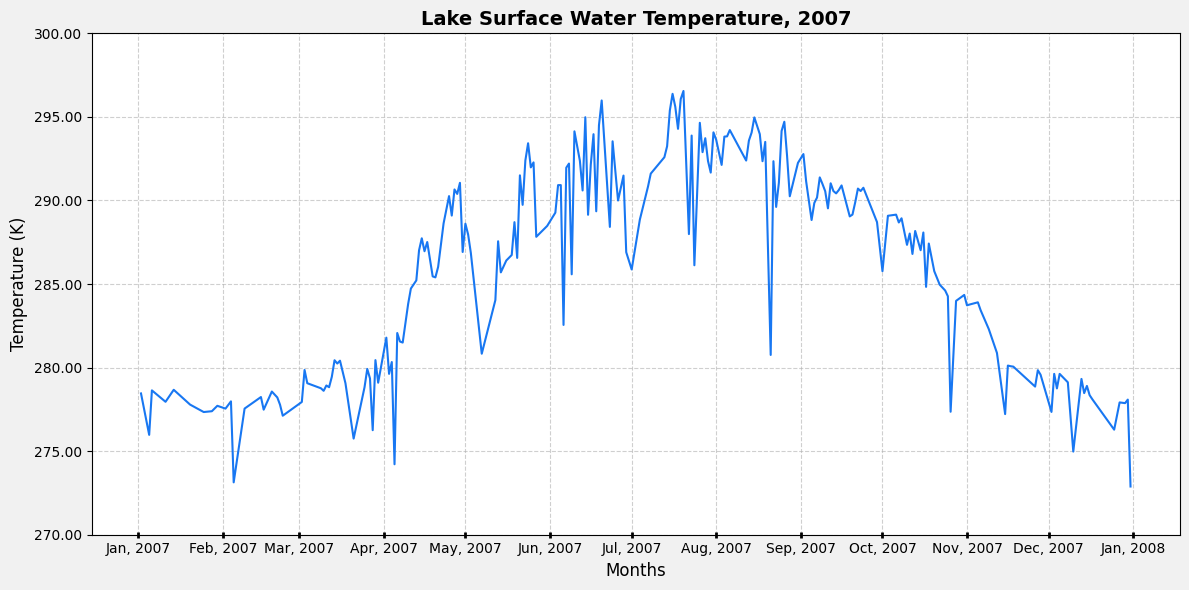

In [12]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator 
import matplotlib.ticker as ticker
import math

# Prepare df for plot
filtered_df_copy = filtered_df.copy()
filtered_df_copy['Date'] = [t.strftime('%Y-%m-%d') for t in filtered_df['Time']]
filtered_df_copy['Date'] = [datetime.strptime(d, '%Y-%m-%d').date() for d in filtered_df_copy['Date']]
vmax = math.ceil(filtered_df_copy['Mean Temperature (K)'].max() / 10) * 10
vmin = math.floor(filtered_df_copy['Mean Temperature (K)'].min() / 10) * 10

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

# Plot the data
ax.plot(filtered_df_copy['Date'],
        filtered_df_copy['Mean Temperature (K)'],
        # marker='o',
        # markersize=3.0,
        linestyle='-',
        color='#1877F2',
        label="Surface Water Temperature",
        )

# Format the axis
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b, %Y'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2)
ax.tick_params(axis='x', which='minor', length=3, direction='inout')

# Set y-axis limit
ax.set_ylim(vmin, vmax)

# Set axis labels and title
ax.set_xlabel('Months', fontsize=12)
ax.set_ylabel('Temperature (K)', fontsize=12)
ax.set_title(f'Lake Surface Water Temperature, {year}', fontsize=14, fontweight='bold')

# Add grid
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### 4.3 Plot Monthly Average

In [13]:
# Prepare data for plot
# Uncertainty calculated using error propagation
filtered_df_monthly = (
    filtered_df_copy.groupby(pd.PeriodIndex(filtered_df_copy["Date"], freq="M"))[[
        "Mean Temperature (K)", "Std Dev", "Uncertainty (K)", "Mean Quality Level"
    ]]
    .agg({
        "Mean Temperature (K)": "mean",
        "Std Dev": lambda x: (x**2).mean()**0.5,
        "Uncertainty (K)": lambda x: (x**2).mean()**0.5,
        "Mean Quality Level": "mean"
    })
    .reset_index()
)

filtered_df_monthly['Date'] = filtered_df_monthly['Date'].dt.to_timestamp()

# Generate the output file path
csv_filename = f"satellite-lake-water-temperature_monthly-mean-{year}.csv"
csv_monthly_means = csv_filepath = os.path.join(csv_folder, "monthly means")
os.makedirs(csv_monthly_means, exist_ok=True)
csv_filepath = os.path.join(csv_monthly_means, csv_filename)

# Export the filtered data to a CSV file if it doesn't already exist
if not os.path.isfile(csv_filepath):
    filtered_df.to_csv(csv_filepath, index=False)
    print(f"Monthly means exported successfully to {csv_filepath}")
else:
    print(f"File already exists at {csv_filepath}. Skipping export.")

filtered_df_monthly.head()

Monthly means exported successfully to .\data\satellite-lake-water-temperature\csv\monthly means\satellite-lake-water-temperature_monthly-mean-2007.csv


,Date,Mean Temperature (K),Std Dev,Uncertainty (K),Mean Quality Level
0,2007-01-01,277.77,0.63,0.31,4.16
1,2007-02-01,277.36,0.35,0.23,4.14
2,2007-03-01,279.02,1.16,0.28,3.70
3,2007-04-01,285.22,1.27,0.27,3.41
4,2007-05-01,288.30,1.75,0.42,3.28


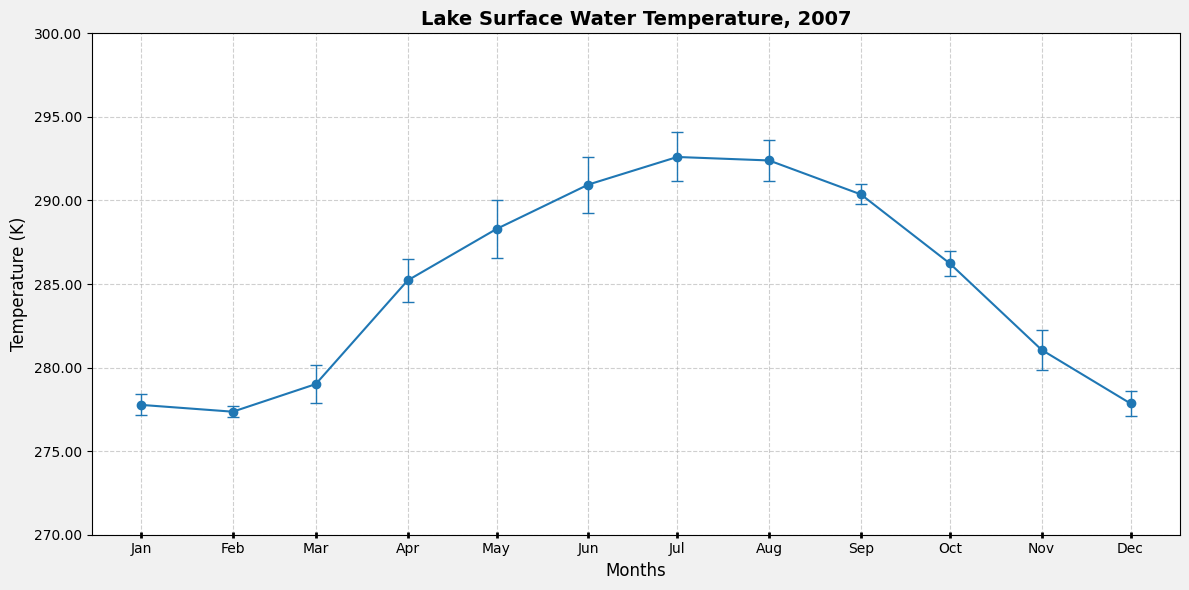

In [14]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import numpy as np

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

# Plot the data
ax.errorbar(
    filtered_df_monthly['Date'],
    filtered_df_monthly['Mean Temperature (K)'],
    yerr=filtered_df_monthly['Std Dev'],
    fmt='o-',
    label='Mean Temperature ± Uncertainty',
    capsize=4,
    elinewidth=1,
    capthick=1,
)

# Format the axis
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b'))

ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2)
ax.tick_params(axis='x', which='minor', length=3, direction='inout')

# Set y-axis limit
ax.set_ylim(vmin, vmax)

# Set axis labels and title
ax.set_xlabel('Months', fontsize=12)
ax.set_ylabel('Temperature (K)', fontsize=12)
ax.set_title(f'Lake Surface Water Temperature, {year}', fontsize=14, fontweight='bold')

# Add grid
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [15]:
# Also display missing months in xaxis

# import matplotlib.dates as mdates

# # Create the figure and axes
# fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

# # Plot the data
# ax.errorbar(
#     filtered_df_monthly['Date'],
#     filtered_df_monthly['Mean Temperature (K)'],
#     yerr=filtered_df_monthly['Std Dev'],
#     fmt='o-',
#     label='Mean Temperature ± Uncertainty',
#     capsize=4,
#     elinewidth=1,
#     capthick=1,
# )

# # Generate all months
# all_months = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='MS')

# # Set x-axis ticks and labels
# ax.set_xticks(all_months)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# ax.set_xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))

# # Set axis labels and title
# ax.set_xlabel('Months', fontsize=12)
# ax.set_ylabel('Temperature (K)', fontsize=12)
# ax.set_title(f'Lake Surface Water Temperature, {year}', fontsize=14, fontweight='bold')

# # Add grid
# ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)

# # Adjust layout and show the plot
# plt.tight_layout()
# plt.show()

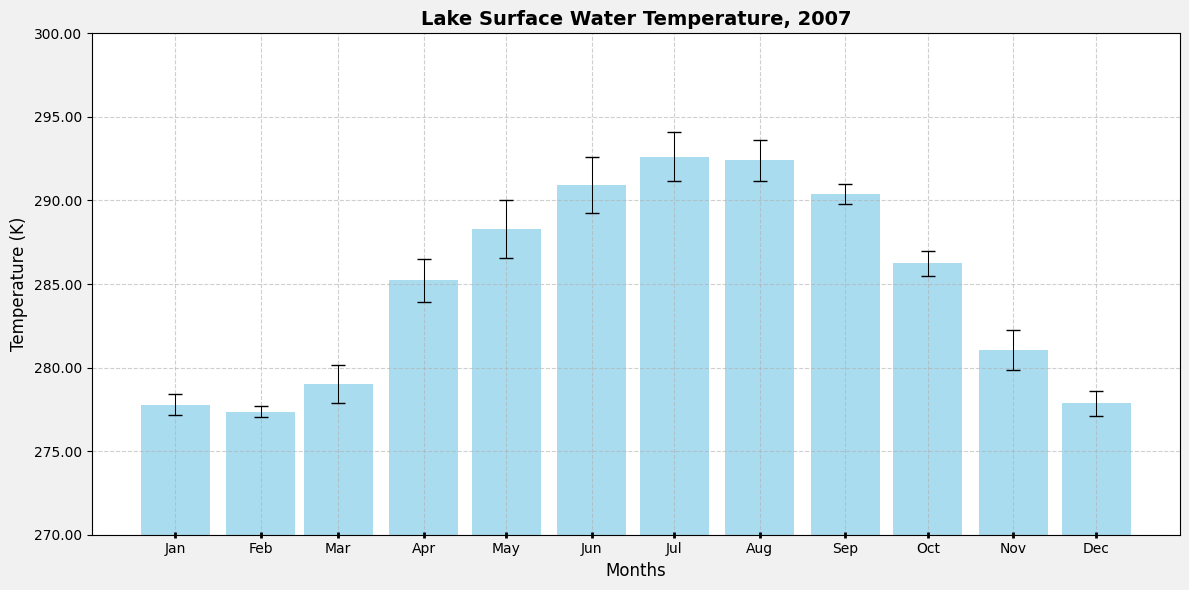

In [16]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')


# Plot the data
ax.bar(filtered_df_monthly['Date'],
       filtered_df_monthly['Mean Temperature (K)'],
       yerr=filtered_df_monthly['Std Dev'],
       color='skyblue',
       alpha=0.7,
       width=25,
       label='Mean Temperature ± Uncertainty',
       capsize=5,
       error_kw=dict(ecolor='black', lw=0.75),
       )

# Format the axis
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2) 
ax.tick_params(axis='x', which='minor', length=3, direction='inout') 

# Set y-axis limit
ax.set_ylim(vmin, vmax)

# Set axis labels and title
ax.set_xlabel('Months', fontsize=12)
ax.set_ylabel('Temperature (K)', fontsize=12)
ax.set_title(f'Lake Surface Water Temperature, {year}', fontsize=14, fontweight='bold')

# Add grid
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## 5. Export merged netCDF4 file to GeoTIFF

### 5.1 Export All-Year Dataset as Merged GeoTIFF File

In [17]:
import rasterio
from rasterio.transform import from_origin
import netCDF4 as nc
from tqdm.notebook import tqdm

def main_export_geotiff(nc_file):
    # Open the NetCDF dataset and read variable data
    nc_dataset = nc.Dataset(nc_file, mode='r')
    temperature_data = nc_dataset[variable_name]
    
    # Extract time variable and convert it to readable dates
    time_var = nc_dataset.variables['time']
    time_units = nc_dataset.variables['time'].units
    time_calendar = getattr(time_var, "calendar", "standard")
    cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
    
    # Compute spatial resolution and raster transformation
    lat = nc_dataset['lat'][:]
    lon = nc_dataset['lon'][:]
    
    pixel_size_lat = (lat.max() - lat.min()) / (len(lat) - 1)
    pixel_size_lon = (lon.max() - lon.min()) / (len(lon) - 1)
    transform = from_origin(lon.min() - pixel_size_lon / 2,
                            lat.min() - pixel_size_lat / 2,
                            pixel_size_lon,
                            -pixel_size_lat
                            )
    
    # Create a merged GeoTIFF containing all time slices as separate bands
    output_filename = f"{variable_name}_{year}_merged.tif"
    output_folder = os.path.join(geotiff_folder, "merged_geotiff")
    os.makedirs(output_folder, exist_ok=True)
    output_filepath = os.path.join(output_folder, output_filename)
    
    if not os.path.isfile(output_filepath):
        # Create a GeoTIFF with multiple bands for each time slice
        with rasterio.open(
            output_filepath,
            "w",
            driver = "GTiff",
            dtype = str(temperature_data.dtype),
            width = temperature_data.shape[2],
            height = temperature_data.shape[1],
            count = temperature_data.shape[0],
            crs = "EPSG:4326",
            nodata = -9999,
            transform=transform,        
        ) as dst:
            for day_index in tqdm(range(temperature_data.shape[0]), desc=f"Exporting merged GeoTIFF file for {year}"):
                band_data = temperature_data[day_index,:,:]
                dt = cftime[day_index]
                band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
                
                # Write each year slice as a band
                dst.write(band_data, day_index + 1)
                dst.set_band_description(day_index + 1, band_desc)
    else:
        print(f"'{output_filename}' already exists. Skipping export.")

# Export merged netCDF file to merged GeoTIFF file
nc_filename_merged = f"satellite-lake-water-temperature_{year}.nc"
nc_filepath_merged = os.path.join(output_folder, nc_filename)
variable_name = 'lake_surface_water_temperature'

main_export_geotiff(nc_filepath_merged)

Exporting merged GeoTIFF file for 2007:   0%|          | 0/365 [00:00<?, ?it/s]

### 5.2 Export All-Year Dataset as individual GeoTIFF File

In [18]:
import rasterio
from rasterio.transform import from_origin
import netCDF4 as nc
from tqdm.notebook import tqdm

def main_export_individual_geotiff(nc_file):
    # Open the NetCDF dataset and read variable data
    nc_dataset = nc.Dataset(nc_file, mode='r')
    temperature_data = nc_dataset[variable_name]
    
    # Extract time variable and convert it to readable dates
    time_var = nc_dataset.variables['time']
    time_units = nc_dataset.variables['time'].units
    time_calendar = getattr(time_var, "calendar", "standard")
    cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
    
    # Compute spatial resolution and raster transformation
    lat = nc_dataset['lat'][:]
    lon = nc_dataset['lon'][:]
    
    pixel_size_lat = (lat.max() - lat.min()) / (len(lat) - 1)
    pixel_size_lon = (lon.max() - lon.min()) / (len(lon) - 1)
    transform = from_origin(lon.min() - pixel_size_lon / 2,
                            lat.min() - pixel_size_lat / 2,
                            pixel_size_lon,
                            -pixel_size_lat
                            )
    
    # Create year folder
    year_folder = os.path.join(geotiff_folder, f"{year}_individual_geotiff")
    os.makedirs(year_folder, exist_ok=True)

    if len(os.listdir(year_folder))==0:
        # Create individual GeoTIFF containing daily time slices
        for day_index in tqdm(range(temperature_data.shape[0]), desc=f"Exporting GeoTIFF files for {year}"):
            dt = cftime[day_index]
            band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
            
            output_filename = f"{variable_name}_{band_desc}.tif"
            output_filepath = os.path.join(year_folder, output_filename)
            
            band_data = temperature_data[day_index,:,:]
            
            # Create a GeoTIFF with multiple bands for each time slice
            with rasterio.open(
                output_filepath,
                "w",
                driver = "GTiff",
                dtype = str(band_data.dtype),
                width = band_data.shape[1],
                height = band_data.shape[0],
                count = 1,
                crs = "EPSG:4326",
                nodata = -9999,
                transform=transform,        
            ) as dst:
                # Write each year slice as a band
                dst.write(band_data, 1)
                dst.set_band_description(1, band_desc)
    else:
        print(f"Folder is not empty. Skipping export.")

# Export merged netCDF file to merged GeoTIFF file
nc_filename_merged = f"satellite-lake-water-temperature_{year}.nc"
nc_filepath_merged = os.path.join(output_folder, nc_filename)
variable_name = 'lake_surface_water_temperature'

main_export_individual_geotiff(nc_filepath_merged)

Exporting GeoTIFF files for 2007:   0%|          | 0/365 [00:00<?, ?it/s]